## Домашнее задание, урок 7

### 1. Загрузка данных

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score 
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

import shap

# load JS visualization code to notebook
shap.initjs()

import itertools

import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Для нашей задачи возьмем данные по доходу населения, полученные в результате переписи: https://archive.ics.uci.edu/ml/datasets/Adult

In [2]:
data = pd.read_csv("adult.data", header=None, names=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 
                                                     'marital-status', 'occupation', 'relationship', 'race', 'sex', 
                                                     'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 
                                                     'income'])

### 2. Обзорный анализ датасета

In [3]:
data.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Целевой переменной является Income (доход). Посмотрим на ее распределение.

In [4]:
data.income.value_counts(dropna=False)

 <=50K    24720
 >50K      7841
Name: income, dtype: int64

Как видим, переменная Income принимает два возможных значения - больше или меньше чем 50 тысяч.

Будем считать положительным классом людей с доходом выше чем 50 тыс. 
Соответственно, сделаем замену значений: >50K на 1, <=50K на 0.

In [5]:
data = data.replace({'income': {' <=50K': 0, ' >50K':1}})

In [6]:
# Посмотрим на количественные признаки
data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456,0.240810
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429,0.427581
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


Весьма странно выглядят признаки capital-gain и capital-loss. Квантили 25%, 50%, 75% равны 0. Похоже, что у большинства опрошенных доходы не выросли и не уменьшились. Для наглядности построим гистограммы распределений.

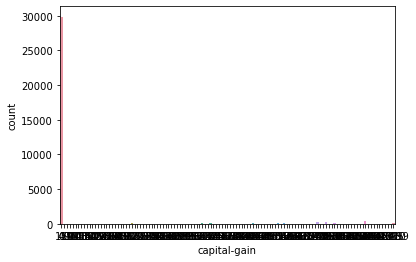

In [7]:
sns.countplot(x=data['capital-gain'])

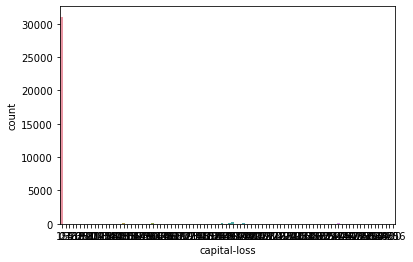

In [8]:
sns.countplot(x=data['capital-loss'])

Видно, что много нулевых значений и существенно меньше других значений.

Посмотрим теперь на корреляцию числовых признаков между собой и с целевой переменной.

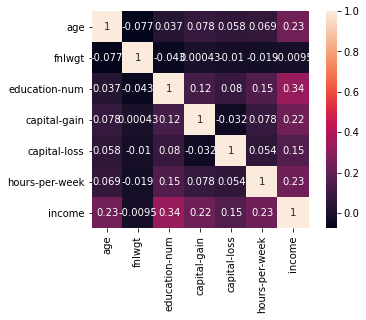

In [9]:
corrmat = data.corr()
sns.heatmap(corrmat, annot=True, square=True)

Видим, что в основном корреляция слабая, и на данном этапе сложно сделать предположение о важности признаков для целевой переменной.

### 3. Feature Engineering

Преобразуем категориальные признаки в дамми-переменные, а для числовых признаков проведем стандартизацию. 

In [10]:
target = 'income'

# количественные признаки
continuos_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

# категориальные признаки
category_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 
            'native-country']

In [11]:
data = pd.get_dummies(data, prefix=category_features)

In [12]:
# Получим список 
dummy_features = data.drop(columns=continuos_features +['income'], axis=1).columns

In [13]:
features = data.drop(columns='income', axis=1).columns

In [14]:
print(features)

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass_ ?', 'workclass_ Federal-gov',
       'workclass_ Local-gov', 'workclass_ Never-worked',
       ...
       'native-country_ Portugal', 'native-country_ Puerto-Rico',
       'native-country_ Scotland', 'native-country_ South',
       'native-country_ Taiwan', 'native-country_ Thailand',
       'native-country_ Trinadad&Tobago', 'native-country_ United-States',
       'native-country_ Vietnam', 'native-country_ Yugoslavia'],
      dtype='object', length=108)


In [15]:
# Разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='income', axis=1), data[target], test_size=0.3, random_state=0)

In [16]:
X_train.head(5)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
32098,45,170871,9,7298,0,60,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
25206,47,108890,9,1831,0,38,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
23491,48,187505,10,0,0,50,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
12367,29,145592,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7054,23,203003,4,0,0,25,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
X_train.shape

(22792, 108)

In [18]:
X_test.shape

(9769, 108)

In [19]:
# Сбросим индексы
X_train.reset_index(inplace=True)
X_test.reset_index(inplace=True)

In [20]:
# Применим StandardScaler для стандартизации данных
scaler = StandardScaler()
X_train_continuos = pd.DataFrame(scaler.fit_transform(X_train[continuos_features]), columns=continuos_features)
X_test_continuos = pd.DataFrame(scaler.fit_transform(X_test[continuos_features]), columns=continuos_features)

In [21]:
X_train = pd.concat([X_train_continuos, X_train[dummy_features]], axis=1)
X_test = pd.concat([X_test_continuos, X_test[dummy_features]], axis=1)

### Классификация данных

In [23]:
classifier = xgb.XGBClassifier()
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [24]:
y_predict =  classifier.predict(X_test)

In [25]:
f1 = f1_score(y_test, y_predict)
print("f1: %.2f%%" % (f1 * 100.0)) 
roc = roc_auc_score(y_test, y_predict)
print("roc: %.2f%%" % (roc * 100.0)) 
rec = recall_score(y_test, y_predict, average='binary')
print("recall: %.2f%%" % (rec * 100.0)) 
prc = precision_score(y_test, y_predict, average='binary')
print("precision: %.2f%%" % (prc * 100.0)) 

f1: 67.02%
roc: 77.34%
recall: 62.07%
precision: 72.83%


### Объяснение важности признаков с помощью SHAP

In [26]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(classifier)

In [27]:
shap_values = explainer.shap_values(X_train)

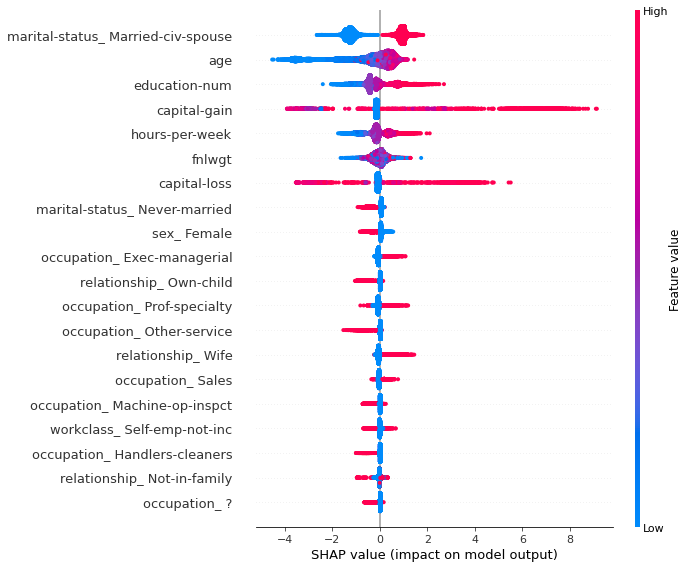

In [28]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

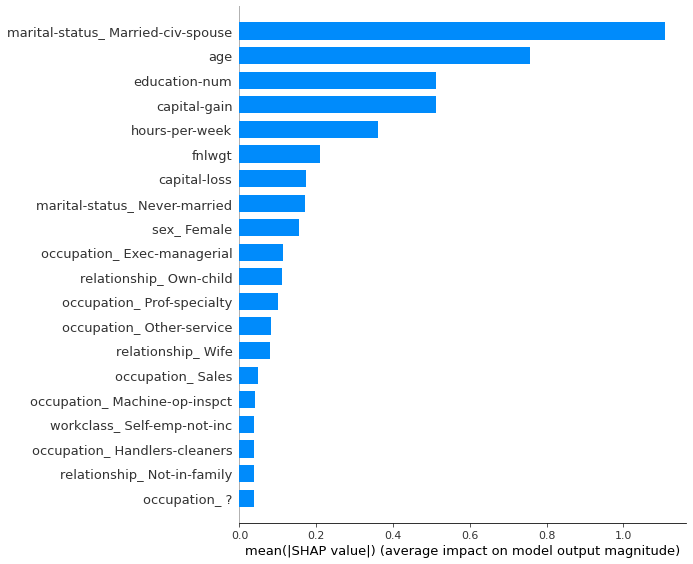

In [29]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

Исходя из графиков, можно сделать такие основные выводы:
- наиболее сильное влияние на уровень дохода оказывают такие признаки как наличие гражданского брака, возраст, количество лет образования, прирост капитала;
- с увеличением возраста увеличивается доход;
- наличие гражданского брака увеличивает доход и т. д.

Теперь посмотрим на несколько отдельных предсказаний.

In [30]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [31]:
shap.force_plot(explainer.expected_value, shap_values[10,:], X_train.iloc[10,:])

In [32]:
shap.force_plot(explainer.expected_value, shap_values[341,:], X_train.iloc[341,:])

Как видим, если рассматривать отдельные наблюдения, то вклад признаков в итоговый результат существенно отличается от усредненных значений. Например, признак capital-gain (прирост капитала), как было показано выше, существенно влияет на увеличение дохода. Для первого из трех примеров (наблюдение 0) так и есть: признак capital-gain вызывает увеличение дохода (значение income равно 1). В то же время во втором примере (наблюдение 10) признак capital-gain вызывает не увеличение, а уменьшение дохода, чего, по идее, не должно быть.